In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from termcolor import colored, cprint
import numpy as np
import statistics
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso ,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as met
import sklearn.svm as svm
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import Pipeline
#from xgboost import XGBRegressor as xgbr

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
dataPath = '/home/thomas/Documents/openclassroom/projet3/cleanData.csv'
df = pd.read_csv(dataPath,sep=',',engine='python',on_bad_lines='skip')

In [5]:
df.shape

(2108, 28)

In [6]:
display(df)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Latitude,Longitude,Address,ENERGYSTARScore,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,1,2015,NonResidential,Hotel,7,1927,1.0,12.0,88434,0,88434,78.900000,80.300000,173.500000,175.100000,6981428.00,7.097539e+06,3.686160e+06,1272388.000,249.43,2.64,47.612190,-122.337997,405 OLIVE WAY,65.0,Hotel,NaN,NaN
1,1,2016,NonResidential,Hotel,7,1927,1.0,12.0,88434,0,88434,81.699997,84.300003,182.500000,189.000000,7226362.50,7.456910e+06,3.946027e+06,1276453.000,249.98,2.83,47.612200,-122.337990,405 Olive way,60.0,Hotel,NaN,NaN
2,2,2015,NonResidential,Hotel,7,1996,1.0,11.0,103566,15064,88502,94.400000,99.000000,191.300000,195.200000,8354235.00,8.765788e+06,3.905411e+06,4448985.000,263.51,2.38,47.613106,-122.333358,724 PINE ST,51.0,Hotel,Parking,Restaurant
3,2,2016,NonResidential,Hotel,7,1996,1.0,11.0,103566,15064,88502,94.800003,97.900002,176.100006,179.399994,8387933.00,8.664479e+06,3.242851e+06,5145082.000,295.86,2.86,47.613170,-122.333930,724 Pine street,61.0,Hotel,Parking,Restaurant
4,3,2015,NonResidential,Hotel,7,1969,1.0,41.0,961990,0,961990,96.600000,99.700000,242.700000,246.500000,73130656.00,7.550627e+07,4.976244e+07,3709900.000,2061.48,1.92,47.613349,-122.337699,1900 5TH AVE,18.0,Hotel,Parking,Swimming Pool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,50062,2016,NonResidential,Hotel,4,2014,1.0,4.0,126823,41539,85284,68.500000,68.500000,169.500000,169.500000,6042399.50,6.042400e+06,4.115620e+06,1926779.000,131.02,1.03,47.654760,-122.347320,3926 Aurora Ave N,72.0,Hotel,Parking,Swimming Pool
2104,50068,2016,NonResidential,Warehouse,2,1955,1.0,1.0,52085,4222,47863,69.199997,80.300003,102.099998,114.599998,3605855.50,4.182622e+06,7.328030e+05,2873052.000,157.70,3.03,47.544250,-122.317760,6518 Ellis,37.0,Non-Refrigerated Warehouse,NaN,NaN
2105,50069,2016,NonResidential,Small- and Mid-Sized Office,2,1929,1.0,2.0,24990,0,24990,176.899994,189.300003,367.000000,378.700012,4420650.50,4.731814e+06,2.167029e+06,2253621.000,134.80,5.39,47.531610,-122.299440,7277 Perimeter Rd.,9.0,Office,NaN,NaN
2106,50081,2016,NonResidential,K-12 School,3,2015,1.0,3.0,45000,0,45000,29.000000,30.600000,91.099998,96.000000,1325972.75,1.397742e+06,1.325973e+06,0.000,9.24,0.21,47.588310,-122.306500,1701 20th Ave South,77.0,K-12 School,Parking,NaN


In [7]:
descripCol =['OSEBuildingID','DataYear',
             'CouncilDistrictCode','Address','Longitude','Latitude','GHGEmissionsIntensity', 'SiteEUI(kBtu/sf)',
            'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
             'SiteEnergyUseWN(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)']
colused = [x for x in df.columns if x not  in descripCol]

print(colused)
print(len(colused)) # colonnes à utiliser

['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
14


In [8]:
dfUsed= df.loc[:,colused]

# functions

In [9]:

def splitSet(X,y,**kwargs):
    if kwargs:
        for key, value in kwargs.items():
            if key == 'test_size':
                X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=value, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
            
    return [X_train, X_test, y_train, y_test]

In [10]:

def Scaled(X_train,X_test):
    stdScaler = StandardScaler()
    stdScaler.fit(X_train)
    X_trainStd = stdScaler.transform(X_train)
    X_testStd = stdScaler.transform(X_test)
    return [X_trainStd, X_testStd]

def testEncoding(X,Y):
    for i in np.linspace(0.1,0.7,1000):
        X_train, X_test, y_train, y_test = splitSet(X,Y,test_size=i)
        #X_train, X_test, y_train, y_test = scaled(X_train, X_test, y_train, y_test)
        X_train, X_test = Scaled(X_train, X_test)
        lr = linear_model.LinearRegression()
        lr.fit(X_train,y_train)
        #print(lr.predict(X_test).shape)
        XPredict = lr.predict(X_test)
        #print(y_test.shape)
        baselineError = np.mean((XPredict-y_test) **2)
        ratioTest.append(i)
        baseError.append(baselineError)
    return {'ratio':ratioTest, 'errors':baseError}




# 1 impact label encoding

# 1-a without label encoding

In [11]:
dfWithoutEnc = dfUsed.loc[:, ~dfUsed.columns.isin(['BuildingType', 'PrimaryPropertyType',
                'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType','ENERGYSTARScore'])]

X = dfWithoutEnc.loc[:, ~dfWithoutEnc.columns.isin(['TotalGHGEmissions','SiteEnergyUse(kBtu)']) ]
Y = dfWithoutEnc.loc[:, 'TotalGHGEmissions']


print(X.columns)

ratioTest=[]
baseError=[]
result = testEncoding(X,Y)
ratioTest =result['ratio']
baseError = result['errors']



Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)'],
      dtype='object')


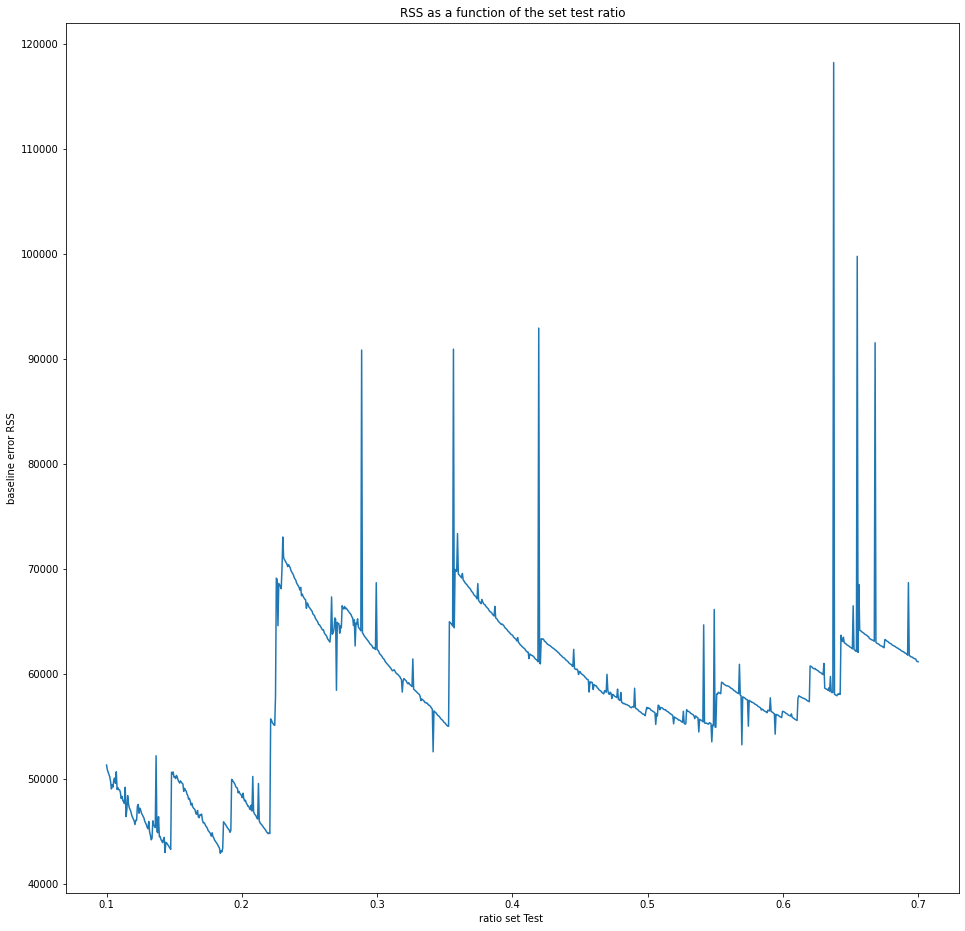

In [12]:
fig, ax = plt.subplots(figsize =(16, 16))
ax.plot(ratioTest, baseError)
plt.xlabel('ratio set Test ')
plt.ylabel('baseline error RSS')
plt.title('RSS as a function of the set test ratio')
plt.show()

# 1-b label encoding

In [13]:
# one-hot encoding
encodedData = pd.get_dummies(dfUsed, columns = ['BuildingType', 'PrimaryPropertyType',
            'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'],
            dummy_na=True,prefix=['BuildT','PrimPoperT','LarPropUseT','SecLarPropUseT','ThiLarPropUseT'],drop_first=False)
display(encodedData)
dfUsed = encodedData

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUse(kBtu),TotalGHGEmissions,ENERGYSTARScore,BuildT_Campus,BuildT_NonResidential,BuildT_Nonresidential COS,BuildT_SPS-District K-12,BuildT_nan,PrimPoperT_Distribution Center,PrimPoperT_Distribution Center\n,PrimPoperT_Hospital,PrimPoperT_Hotel,PrimPoperT_K-12 School,PrimPoperT_Large Office,PrimPoperT_Low-Rise Multifamily,PrimPoperT_Medical Office,PrimPoperT_Mixed Use Property,PrimPoperT_Non-Refrigerated Warehouse,PrimPoperT_Office,PrimPoperT_Other,PrimPoperT_Refrigerated Warehouse,PrimPoperT_Residence Hall,PrimPoperT_Residence Hall/Dormitory,PrimPoperT_Retail Store,PrimPoperT_SPS-District K-12,PrimPoperT_Self-Storage Facility\n,PrimPoperT_Senior Care Community,PrimPoperT_Small- and Mid-Sized Office,PrimPoperT_Supermarket / Grocery Store,PrimPoperT_Supermarket/Grocery Store,PrimPoperT_Warehouse,PrimPoperT_Worship Facility,PrimPoperT_nan,LarPropUseT_Bank Branch,LarPropUseT_Courthouse,LarPropUseT_Distribution Center,LarPropUseT_Financial Office,LarPropUseT_Hospital (General Medical & Surgical),LarPropUseT_Hotel,LarPropUseT_K-12 School,LarPropUseT_Laboratory,LarPropUseT_Manufacturing/Industrial Plant,LarPropUseT_Medical Office,LarPropUseT_Multifamily Housing,...,SecLarPropUseT_Other,SecLarPropUseT_Other - Education,SecLarPropUseT_Other - Entertainment/Public Assembly,SecLarPropUseT_Other - Recreation,SecLarPropUseT_Other - Restaurant/Bar,SecLarPropUseT_Other - Services,SecLarPropUseT_Parking,SecLarPropUseT_Performing Arts,SecLarPropUseT_Pre-school/Daycare,"SecLarPropUseT_Repair Services (Vehicle, Shoe, Locksmith, etc)",SecLarPropUseT_Restaurant,SecLarPropUseT_Retail Store,SecLarPropUseT_Self-Storage Facility,SecLarPropUseT_Supermarket/Grocery Store,SecLarPropUseT_Swimming Pool,SecLarPropUseT_Worship Facility,SecLarPropUseT_nan,ThiLarPropUseT_Bank Branch,ThiLarPropUseT_Bar/Nightclub,ThiLarPropUseT_Convenience Store without Gas Station,ThiLarPropUseT_Data Center,ThiLarPropUseT_Distribution Center,ThiLarPropUseT_Enclosed Mall,ThiLarPropUseT_Financial Office,ThiLarPropUseT_Fitness Center/Health Club/Gym,ThiLarPropUseT_Food Service,ThiLarPropUseT_Laboratory,ThiLarPropUseT_Manufacturing/Industrial Plant,ThiLarPropUseT_Medical Office,ThiLarPropUseT_Multifamily Housing,ThiLarPropUseT_Non-Refrigerated Warehouse,ThiLarPropUseT_Office,ThiLarPropUseT_Other,ThiLarPropUseT_Other - Education,ThiLarPropUseT_Other - Entertainment/Public Assembly,ThiLarPropUseT_Other - Recreation,ThiLarPropUseT_Other - Restaurant/Bar,ThiLarPropUseT_Other - Services,ThiLarPropUseT_Other - Technology/Science,ThiLarPropUseT_Other/Specialty Hospital,ThiLarPropUseT_Parking,"ThiLarPropUseT_Personal Services (Health/Beauty, Dry Cleaning, etc)",ThiLarPropUseT_Pre-school/Daycare,ThiLarPropUseT_Refrigerated Warehouse,ThiLarPropUseT_Restaurant,ThiLarPropUseT_Retail Store,ThiLarPropUseT_Social/Meeting Hall,ThiLarPropUseT_Swimming Pool,ThiLarPropUseT_Worship Facility,ThiLarPropUseT_nan
0,1927,1.0,12.0,88434,0,88434,6981428.00,249.43,65.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1927,1.0,12.0,88434,0,88434,7226362.50,249.98,60.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1996,1.0,11.0,103566,15064,88502,8354235.00,263.51,51.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1996,1.0,11.0,103566,15064,88502,8387933.00,295.86,61.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1969,1.0,41.0,961990,0,961990,731

In [14]:
dfUsed.isna().any().any()

False

def scaled(df):
    columnsScaled=df.columns
    dfScaled=StandardScaler().fit_transform(df)
    dfScaled = pd.DataFrame(dfScaled,columns=columnsScaled)
    return dfScaled

dfUsed = scaled(dfUsed)

In [15]:
for i in dfUsed.columns:
    print(f"colonne : {i} , minimum: {dfUsed[i].min()}, maximum : {dfUsed[i].max()}\n")

colonne : YearBuilt , minimum: 1900, maximum : 2015

colonne : NumberofBuildings , minimum: 1.0, maximum : 8.0

colonne : NumberofFloors , minimum: 1.0, maximum : 55.0

colonne : PropertyGFATotal , minimum: 15398, maximum : 1592914

colonne : PropertyGFAParking , minimum: 0, maximum : 368980

colonne : PropertyGFABuilding(s) , minimum: 15398, maximum : 1380959

colonne : SiteEnergyUse(kBtu) , minimum: 56493.0, maximum : 104977248.0

colonne : TotalGHGEmissions , minimum: 0.35, maximum : 3894.01

colonne : ENERGYSTARScore , minimum: 1.0, maximum : 100.0

colonne : BuildT_Campus , minimum: 0, maximum : 1

colonne : BuildT_NonResidential , minimum: 0, maximum : 1

colonne : BuildT_Nonresidential COS , minimum: 0, maximum : 1

colonne : BuildT_SPS-District K-12 , minimum: 0, maximum : 1

colonne : BuildT_nan , minimum: 0, maximum : 0

colonne : PrimPoperT_Distribution Center , minimum: 0, maximum : 1

colonne : PrimPoperT_Distribution Center
 , minimum: 0, maximum : 1

colonne : PrimPoperT

In [16]:
display(dfUsed.columns)

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'ENERGYSTARScore', 'BuildT_Campus',
       ...
       'ThiLarPropUseT_Parking',
       'ThiLarPropUseT_Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'ThiLarPropUseT_Pre-school/Daycare',
       'ThiLarPropUseT_Refrigerated Warehouse', 'ThiLarPropUseT_Restaurant',
       'ThiLarPropUseT_Retail Store', 'ThiLarPropUseT_Social/Meeting Hall',
       'ThiLarPropUseT_Swimming Pool', 'ThiLarPropUseT_Worship Facility',
       'ThiLarPropUseT_nan'],
      dtype='object', length=132)

In [17]:

X = dfUsed.loc[:, ~dfUsed.columns.isin(['TotalGHGEmissions','ENERGYSTARScore','SiteEnergyUse(kBtu)']) ]
Y = dfUsed.loc[:, 'TotalGHGEmissions']


print(X.columns)

ratioTest=[]
baseError=[]
result = testEncoding(X,Y)

ratioTest =result['ratio']
baseError = result['errors']


Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'BuildT_Campus',
       'BuildT_NonResidential', 'BuildT_Nonresidential COS',
       'BuildT_SPS-District K-12',
       ...
       'ThiLarPropUseT_Parking',
       'ThiLarPropUseT_Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'ThiLarPropUseT_Pre-school/Daycare',
       'ThiLarPropUseT_Refrigerated Warehouse', 'ThiLarPropUseT_Restaurant',
       'ThiLarPropUseT_Retail Store', 'ThiLarPropUseT_Social/Meeting Hall',
       'ThiLarPropUseT_Swimming Pool', 'ThiLarPropUseT_Worship Facility',
       'ThiLarPropUseT_nan'],
      dtype='object', length=129)


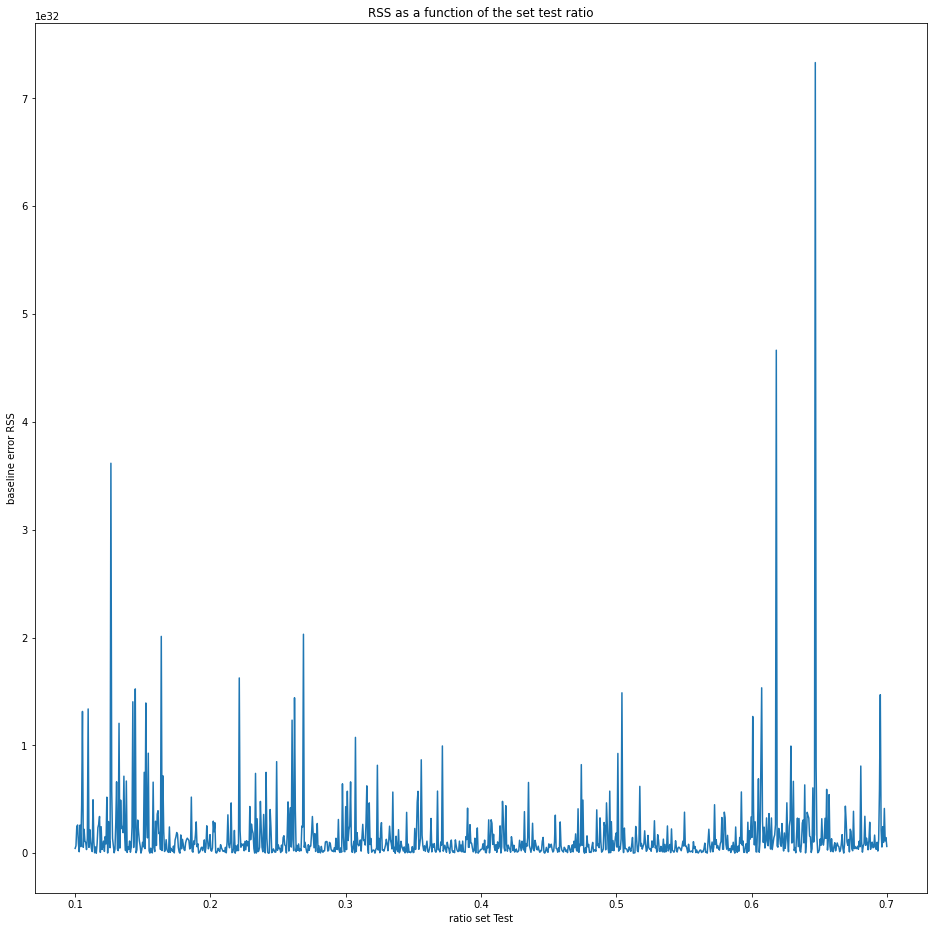

In [18]:
fig, ax = plt.subplots(figsize =(16, 16))
ax.plot(ratioTest, baseError)
plt.xlabel('ratio set Test')
plt.ylabel('baseline error RSS')
plt.title('RSS as a function of the set test ratio')
plt.show()

On remarque quand faisant varier la proportion des données de test en fonction de la RSS, on trouve des biais d'échantillonages. Certains models ne sont pas du tout capables de prédire les données de test. Le rajout des colonnes 'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType'et 'ThirdLargestPropertyUseType' ne permet pas de lever ce biais.

# 2 Linear Regression

## intro

In [19]:
X = dfUsed.loc[:, ~dfUsed.columns.isin(['TotalGHGEmissions','ENERGYSTARScore','SiteEnergyUse(kBtu)']) ]
Y = dfUsed.loc[:, 'TotalGHGEmissions']

X_train, X_test, y_train, y_test = splitSet(X,Y)
X_train, X_test = Scaled(X_train, X_test)

In [20]:
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
baselineError = np.mean((lr.predict(X_test)-y_test) **2)
print(baselineError)

1.2960765334004407e+31


In [21]:
n_alphas = 1000
alphas = np.logspace(-3, 3, n_alphas)

In [22]:
ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baselineError, np.mean((ridge.predict(X_test) - y_test) ** 2)])

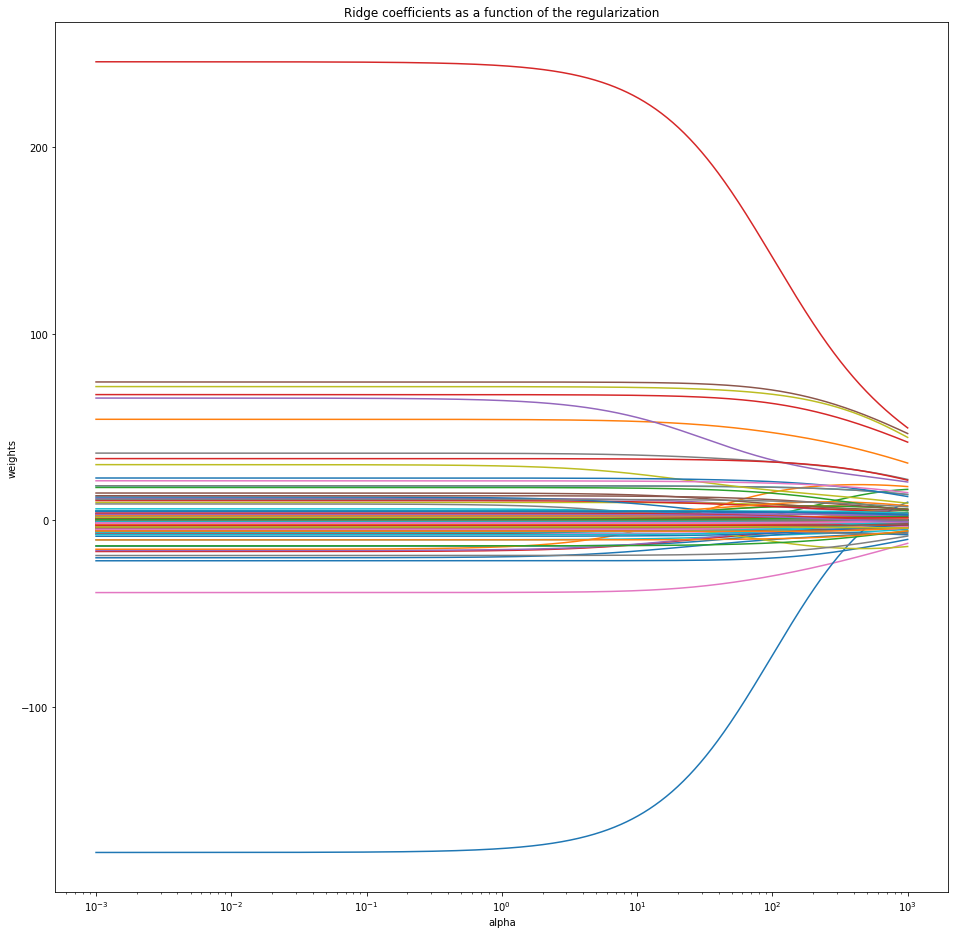

In [23]:
fig, ax = plt.subplots(figsize =(16, 16))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

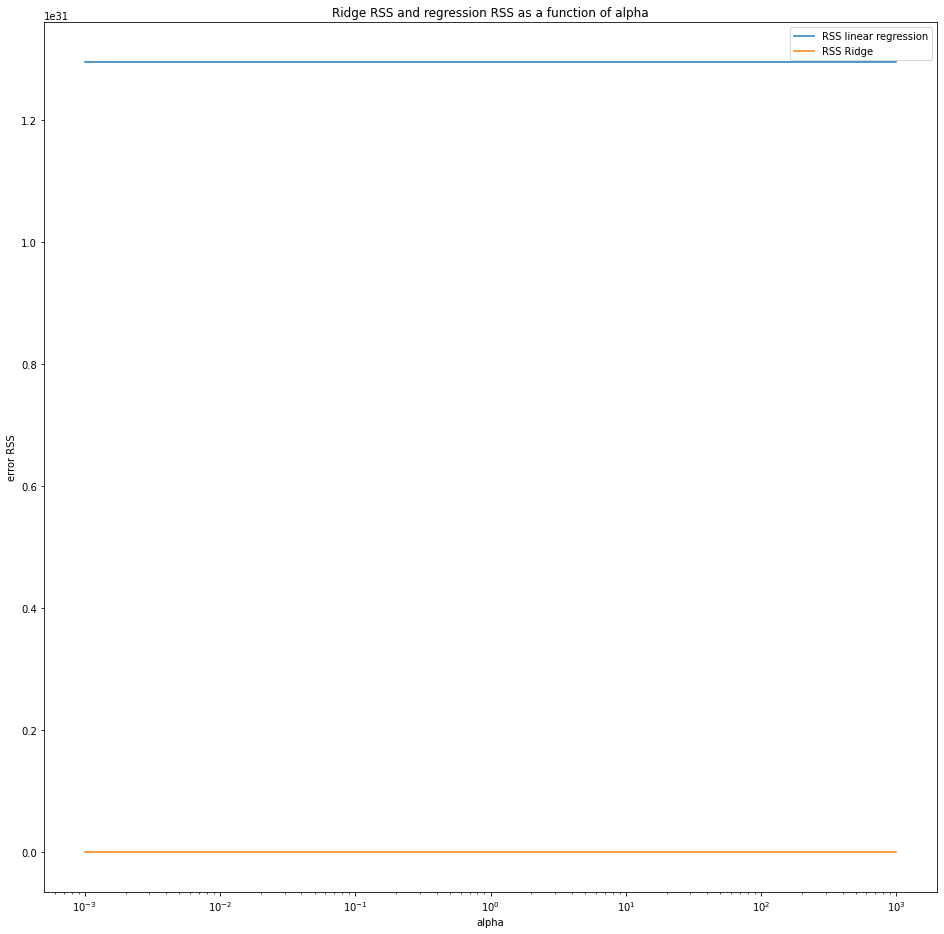

In [24]:
fig, ax = plt.subplots(figsize =(16, 16))
ax = plt.gca()

ax.plot(alphas, np.array(errors)[:,0],label='RSS linear regression')
ax.plot(alphas, np.array(errors)[:,1],label='RSS Ridge')
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error RSS')
plt.title("Ridge RSS and regression RSS as a function of alpha")
plt.legend();
plt.axis('tight')
plt.show()

In [25]:
min(errors)

[1.2960765334004407e+31, 26239.974201773024]

## 2-a  comparaison Ridge Lasso 

In [26]:

class modelClass:
    def __init__(self,modelList):
        self.modelList = modelList
        for i in self.modelList:
            exec("self."+i +" = linear_model." + str(i) +"()" )
            exec("self."+i+".error = []")
            
def predictModel(obj,xtrain,ytrain,xtest):
    obj.fit(xtrain,ytrain)
    return obj.predict(xtest)

In [27]:
X = dfUsed.loc[:, ~dfUsed.columns.isin(['TotalGHGEmissions','ENERGYSTARScore','SiteEnergyUse(kBtu)']) ]
Y = dfUsed.loc[:, 'TotalGHGEmissions']

X_train, X_test, y_train, y_test = splitSet(X,Y)
X_train, X_test = Scaled(X_train, X_test)

In [28]:
n_alphas = 1000
alphas = np.logspace(-3, 3, n_alphas)

In [29]:
modelList = ['Ridge','Lasso','LinearRegression']
model = modelClass(modelList)
lrPredict = predictModel(model.LinearRegression,X_train,y_train,X_test)
for a in alphas:
    model.Ridge.set_params(alpha=a)
    ridgePredict = predictModel(model.Ridge,X_train,y_train,X_test)
    model.Lasso.set_params(alpha=a,tol=1E-2,max_iter=5000)
    lassoPredict = predictModel(model.Lasso,X_train,y_train,X_test)
    model.LinearRegression.error.append([ np.mean((lrPredict - y_test) ** 2), met.mean_squared_error(y_test,lrPredict),
                       met.r2_score(y_test,lrPredict)])
    model.Lasso.error.append([ np.mean((lassoPredict - y_test) ** 2), met.mean_squared_error(y_test,lassoPredict),
                       met.r2_score(y_test,lassoPredict)])
    model.Ridge.error.append([ np.mean((ridgePredict - y_test) ** 2), met.mean_squared_error(y_test,ridgePredict),
                       met.r2_score(y_test,ridgePredict)])
    

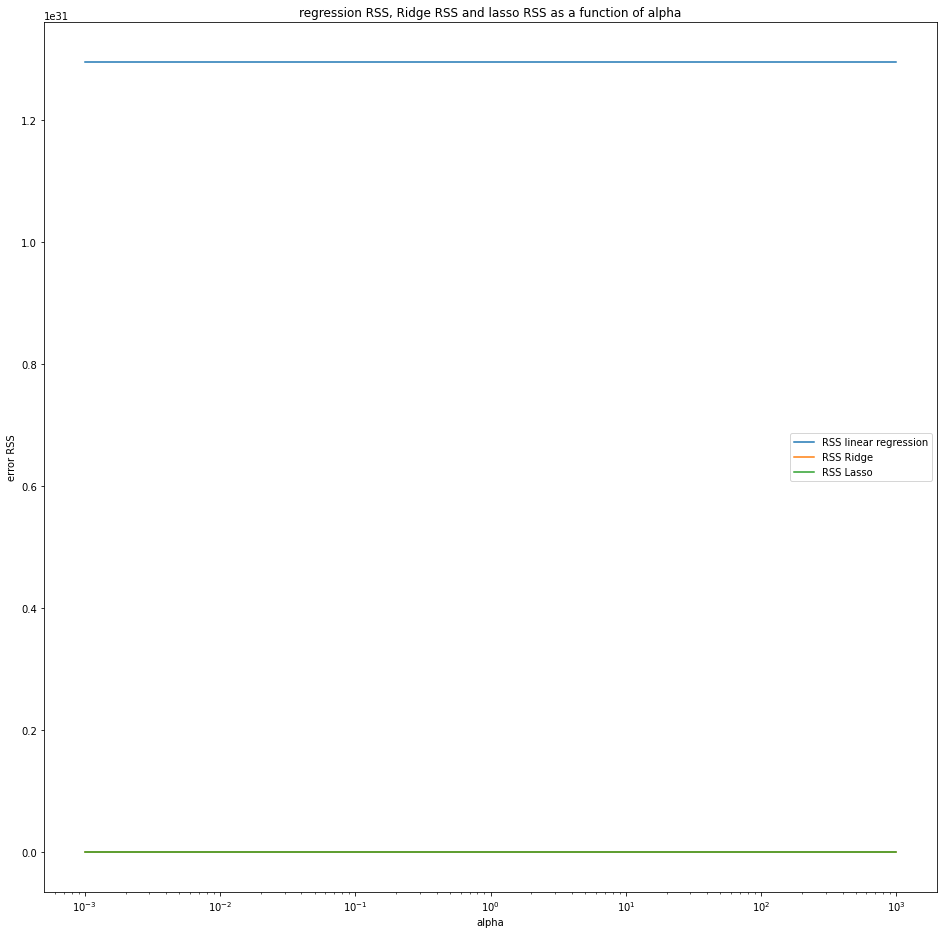

In [30]:
fig, ax = plt.subplots(figsize =(16, 16))
ax = plt.gca()

ax.plot(alphas, np.array(model.LinearRegression.error)[:,0],label='RSS linear regression')
ax.plot(alphas, np.array(model.Ridge.error)[:,0],label='RSS Ridge')
ax.plot(alphas, np.array(model.Lasso.error)[:,0],label='RSS Lasso')
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error RSS')
plt.title("regression RSS, Ridge RSS and lasso RSS as a function of alpha")
plt.legend();
plt.axis('tight')
plt.show()

## 2-b impact cross validation

on cherche à savoir l'impact de la crossvalidation sur les differentes erreurs RSS, RMSE et R² pour differents modèles comparé à 
un train test de 66% des données.

### sans cross validation

In [31]:
X = dfUsed.loc[:, ~dfUsed.columns.isin(['TotalGHGEmissions','ENERGYSTARScore','SiteEnergyUse(kBtu)']) ]
Y = dfUsed.loc[:, 'TotalGHGEmissions']

X_train, X_test, y_train, y_test = splitSet(X,Y)
X_train, X_test = Scaled(X_train, X_test)

In [32]:

from sklearn.pipeline import Pipeline

n_alphas = 1000
a = np.logspace(-4, 4, n_alphas)

estimators = ['linear','ridge','lasso']
             
paramGrid ={'linear':{},
            'ridge':{'estimator__alpha':a},
            'lasso':{'estimator__alpha':a}
           }

models = {
    'linear': Pipeline(steps=[('estimator',linear_model.LinearRegression())]),
    'ridge': Pipeline(steps=[('estimator',Ridge(tol=1E-2,max_iter=5000))]),
    'lasso': Pipeline(steps=[('estimator',Lasso(tol=1E-1,max_iter=5000))]),
    
}


for esti in estimators:
    #print(models[esti].get_params().keys())
    gsc = GridSearchCV(models[esti],paramGrid[esti],cv=[(slice(None), slice(None))])
    gsc.fit(X_train,y_train)
    yPredict = gsc.predict(X_test)
    print(f"Modèle : {esti}\t Score R2 : {r2_score(y_test, yPredict) * 100} \t RMSE : {MSE(y_test, yPredict,squared=False)}")
    

Modèle : linear	 Score R2 : -1.9509571708765715e+28 	 RMSE : 3600106294820252.5
Modèle : ridge	 Score R2 : 53.32767925055491 	 RMSE : 176.08451041705197
Modèle : lasso	 Score R2 : 53.28633611167939 	 RMSE : 176.16248248703752


In [33]:
modelList = ['Ridge','Lasso','ElasticNet','LinearRegression']
model = modelClass(modelList)
n_alphas = 1000
alphas = np.logspace(-4, 4, n_alphas)

for a in alphas:
    model.Ridge.set_params(alpha=a,tol=1E-2,max_iter=5000)
    model.Lasso.set_params(alpha=a,tol=1E-1,max_iter=5000)
    lrPredict = predictModel(model.LinearRegression,X_train,y_train,X_test)
    ridgePredict = predictModel(model.Ridge,X_train,y_train,X_test)
    lassoPredict = predictModel(model.Lasso,X_train,y_train,X_test)
    model.LinearRegression.error.append([ np.mean((lrPredict - y_test) ** 2), met.mean_squared_error(y_test,lrPredict),
                   met.r2_score(y_test,lrPredict)])
    model.Lasso.error.append([ np.mean((lassoPredict - y_test) ** 2), met.mean_squared_error(y_test,lassoPredict),
                   met.r2_score(y_test,lassoPredict)])
    model.Ridge.error.append([ np.mean((ridgePredict - y_test) ** 2), met.mean_squared_error(y_test,ridgePredict),
                   met.r2_score(y_test,ridgePredict)])
    

In [34]:
errors = np.array(model.LinearRegression.error)
errorsRidge = np.array(model.Ridge.error)
errorsLasso = np.array(model.Lasso.error)
errorWithoutCrossV = {'linear':errors,'ridge':errorsRidge,'lasso': errorsLasso}
cprint("Erreurs pour différents modèles sans cross validation :\n",'red','on_white')
print(f"Linear Regression : \n RSS:{min(errors[:,0])} \t RMSE: {np.sqrt(min(errors[:,1]))} \t R²:{max(errors[:,2])}")
print(f"Ridge Regression : \n RSS:{min(errorsRidge[:,0])} \t RMSE: {np.sqrt(min(errorsRidge[:,1]))} \t R²:{max(errorsRidge[:,2])}")
print(f"Lasso Regression : \n RSS:{min(errorsLasso[:,0])} \t RMSE: {np.sqrt(min(errorsLasso[:,1]))} \t R²:{max(errorsLasso[:,2])}")            

Erreurs pour différents modèles sans cross validation :

Linear Regression : 
 RSS:1.2960765334004407e+31 	 RMSE: 3600106294820252.5 	 R²:-1.9509571708765714e+26
Ridge Regression : 
 RSS:26240.092638601716 	 RMSE: 161.98793979368253 	 R²:0.6050133184385904
Lasso Regression : 
 RSS:25229.22093828036 	 RMSE: 158.83708930309808 	 R²:0.6202297608457674


### Cross Validation:

In [35]:
X = dfUsed.loc[:, ~dfUsed.columns.isin(['TotalGHGEmissions','ENERGYSTARScore','SiteEnergyUse(kBtu)']) ]
Y = dfUsed.loc[:, 'TotalGHGEmissions']

X_train, X_test, y_train, y_test = splitSet(X,Y)
#X_train, X_test = Scaled(X_train, X_test)

In [36]:
k=5
n_alphas = 1000
a = np.logspace(-4, 4, n_alphas)
kf = KFold(n_splits=k,shuffle=True,random_state=6)

estimators = ['linear','ridge','lasso']
             
paramGrid ={'linear':{},
            'ridge':{'estimator__alpha':a},
            'lasso':{'estimator__alpha':a}
           }

models = {
    'linear': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',linear_model.LinearRegression())]),
    'ridge': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',Ridge(tol=1E-2,max_iter=5000))]),
    'lasso': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',Lasso(tol=1E-1,max_iter=5000))]),
    
}


for esti in estimators:
    #print(models[esti].get_params().keys())
    gsc = GridSearchCV(models[esti],paramGrid[esti],cv=kf)
    gsc.fit(X_train,y_train)
    yPredict = gsc.predict(X_test)
    print(f"modèle: {esti} \t Score R2 : {r2_score(y_test, yPredict) * 100} \t RMSE : {MSE(y_test, yPredict,squared=False)}  \t {gsc.best_params_}")

modèle: linear 	 Score R2 : -1.9509571708765715e+28 	 RMSE : 3600106294820252.5  	 {}
modèle: ridge 	 Score R2 : 60.308084371867054 	 RMSE : 162.3837197811762  	 {'estimator__alpha': 389.5745615775501}
modèle: lasso 	 Score R2 : 56.295083136580516 	 RMSE : 170.39490517859124  	 {'estimator__alpha': 2.271728133026903}


In [37]:
X = dfUsed.loc[:, ~dfUsed.columns.isin(['TotalGHGEmissions','ENERGYSTARScore','SiteEnergyUse(kBtu)']) ]
Y = dfUsed.loc[:, 'TotalGHGEmissions'] 
X_train, X_test, Y_train, Y_test = splitSet(X,Y)

In [38]:
import time
import copy
k = 5
kf = KFold(n_splits=k,shuffle=True,random_state=6)
modelList = ['Ridge','Lasso','LinearRegression']
modelDict = {'Ridge':linear_model.Ridge(), 'Lasso':linear_model.Lasso(),'LinearRegression':linear_model.LinearRegression()}
#model2 = modelClass(modelList)
n_alphas = 100
a=None
alphas = np.logspace(-3, 3, n_alphas)
#params={'LinearRegression':{}, 'Ridge': {'alpha':a},'Lasso':{'alpha':a, 'tol':1E-2,'max_iter':5000}}

kfolds = [i for i in kf.split(X_train)] # les differents splits train/validation

start = time.time()
bestModel={} # les meilleurs model sélectionés
for i in modelList:
    bestModel[str(i)] = [None,None]
    for a in alphas:
        params={'LinearRegression':{}, 'Ridge': {'alpha':a, 'tol': 1E-2,'max_iter': 5000},'Lasso':{'alpha':a, 'tol':1E-1,'max_iter':5000}}
        errorPredictKfold=[] # erreur pour chaques Kfolds
        KfoldModel=[] # obj temporaire pour contenir les 5 modèles
        for j in range(len(kfolds)): # 5 kfolds
            xtrain = X_train.iloc[kfolds[j][0]]
            ytrain = Y_train.iloc[kfolds[j][0]]
            xValidation = X_train.iloc[kfolds[j][1]]
            yValidation = Y_train.iloc[kfolds[j][1]]
            xtrain , xValidation = Scaled(xtrain,xValidation)
            modelDict[i].set_params(**params[i])
            modelDict[i].fit(xtrain,ytrain)
            KfoldModel.append(modelDict[i])
            predict = modelDict[i].predict(xValidation)
            errorPredictKfold.append(MSE(yValidation,predict,squared=False))
        mean = np.mean(errorPredictKfold)
        if bestModel[str(i)][0] == None or bestModel[str(i)][0]>mean:
            #print(f"model :{i} \t old Model: {bestModel[str(i)][0]} \t new model: {mean} \t alpha:{a}")
            bestModel[str(i)][0] = mean
            bestModel[str(i)][1] = copy.deepcopy(KfoldModel)
            

stdScaler = StandardScaler()
stdScaler.fit(X_test)
X_testStd = stdScaler.transform(X_test)
for key in bestModel.keys():
    errorList=[]
    for i in range(len(bestModel[key][1])):
        prediction = bestModel[key][1][i].predict(X_testStd)
        error = MSE(Y_test, prediction,squared=False)
        errorList.append(error)
    mean = np.mean(errorList)
    print(f"Modèle : {key} \t RMSE : {mean}")
    

fin =time.time()
#print(fin - start)
        

            

Modèle : Ridge 	 RMSE : 156.12294997087872
Modèle : Lasso 	 RMSE : 160.49863617300662
Modèle : LinearRegression 	 RMSE : 8542187295917219.0


In [39]:
print(bestModel) # modèles sélectionnés

{'Ridge': [221.3249906267083, [Ridge(alpha=327.4549162877732, max_iter=5000, tol=0.01), Ridge(alpha=327.4549162877732, max_iter=5000, tol=0.01), Ridge(alpha=327.4549162877732, max_iter=5000, tol=0.01), Ridge(alpha=327.4549162877732, max_iter=5000, tol=0.01), Ridge(alpha=327.4549162877732, max_iter=5000, tol=0.01)]], 'Lasso': [218.7823402821291, [Lasso(alpha=2.1544346900318843, max_iter=5000, tol=0.1), Lasso(alpha=2.1544346900318843, max_iter=5000, tol=0.1), Lasso(alpha=2.1544346900318843, max_iter=5000, tol=0.1), Lasso(alpha=2.1544346900318843, max_iter=5000, tol=0.1), Lasso(alpha=2.1544346900318843, max_iter=5000, tol=0.1)]], 'LinearRegression': [1625075666223672.5, [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]]}


#### avec les fonction built in

In [40]:
X = dfUsed.loc[:, ~dfUsed.columns.isin(['TotalGHGEmissions','ENERGYSTARScore','SiteEnergyUse(kBtu)']) ]
Y = dfUsed.loc[:, 'TotalGHGEmissions']

X_train, X_test, y_train, y_test = splitSet(X,Y)
X_train, X_test = Scaled(X_train, X_test)

In [41]:
n_alphas = 1000
a = np.logspace(-4, 4, n_alphas)

CV=5

ridgeCV = linear_model.RidgeCV()
LassoCV = linear_model.LassoCV()
Elsatic = linear_model.ElasticNetCV()

errors = []
#coefsRidge = []
errorsRidge = []
#coefsLasso = []
errorsLasso = []
#coefselastic = []
errorselastic = []


lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
lrPredict = lr.predict(X_test)
print(f"Modèle: Linéaire \t Score R2 : {r2_score(y_test, lrPredict) * 100} \t RMSE : {MSE(y_test, lrPredict,squared=False)}")

ridgeCV.set_params(alphas=a,cv=CV)
ridgeCV.fit(X_train, y_train)
ridgePredict = ridgeCV.predict(X_test)
print(f"Modèle: Ridge \t Score R2 : {r2_score(y_test, ridgePredict) * 100} \t RMSE : {MSE(y_test, ridgePredict,squared=False)}")
LassoCV.set_params(alphas=a,cv=CV,tol=1E-1,max_iter=5000)
LassoCV.fit(X_train, y_train)
lassoPredict = LassoCV.predict(X_test)
print(f"Modèle: Lasso \t Score R2 : {r2_score(y_test, lassoPredict) * 100} \t RMSE : {MSE(y_test, lassoPredict,squared=False)}")
    
errors.append([ np.mean((lr.predict(X_test) - y_test) ** 2), met.mean_squared_error(y_test,lrPredict),
                       met.r2_score(y_test,lrPredict)])
errorsRidge.append([ np.mean((ridgePredict - y_test) ** 2), met.mean_squared_error(y_test,ridgePredict),
                       met.r2_score(y_test,ridgePredict)])
errorsLasso.append([ np.mean((lassoPredict - y_test) ** 2), met.mean_squared_error(y_test,lassoPredict),
                       met.r2_score(y_test,lassoPredict)])

Modèle: Linéaire 	 Score R2 : -1.9509571708765715e+28 	 RMSE : 3600106294820252.5
Modèle: Ridge 	 Score R2 : 60.50133184385904 	 RMSE : 161.98793979368253
Modèle: Lasso 	 Score R2 : 56.30539740036682 	 RMSE : 170.37479758167035


In [42]:
errors = np.array(errors)
errorsRidge = np.array(errorsRidge)
errorsLasso = np.array(errorsLasso)
cprint("Erreurs pour différents modèles avec cross validation :\n",'red','on_white')
print(f"Linear Regression : \n RSS:{min(errors[:,0])} \t RMSE: {np.sqrt(min(errors[:,1]))} \t R²:{min(errors[:,2])}")
print(f"Ridge Regression : \n RSS:{min(errorsRidge[:,0])} \t RMSE: {np.sqrt(min(errorsRidge[:,1]))} \t R²:{min(errorsRidge[:,2])}")
print(f"Lasso Regression : \n RSS:{min(errorsLasso[:,0])} \t RMSE: {np.sqrt(min(errorsLasso[:,1]))} \t R²:{min(errorsLasso[:,2])}")




Erreurs pour différents modèles avec cross validation :

Linear Regression : 
 RSS:1.2960765334004407e+31 	 RMSE: 3600106294820252.5 	 R²:-1.9509571708765714e+26
Ridge Regression : 
 RSS:26240.092638601716 	 RMSE: 161.98793979368253 	 R²:0.6050133184385904
Lasso Regression : 
 RSS:29027.571650995145 	 RMSE: 170.37479758167035 	 R²:0.5630539740036682


on remarque que la validation croisé diminue légérement la RMSE mais  pas de manière significative

# 3 impact StarEnergyScore with cross validation

In [43]:
def importantFeaturesPlot(liste):
    
    fig=plt.figure(figsize=[38,78])
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    plt.subplot(2,1,1)
    plt.title(" Important Features of the Random forest without EnergyStar Score.",size=16)
    plt.barh(liste[0], liste[1],color="#28a2b4",edgecolor='black')
    plt.subplot(2,1,2)
    plt.title(" Important Features of the Random forest with EnergyStar Score.",size=16)
    plt.barh(liste[2], liste[3],color="#28a2b4",edgecolor='black')
    
    plt.show()

def modelisation(X_train,X_test, y_train,y_test):
    k=5
    n_alphas = 1000
    a = np.logspace(-4, 4, n_alphas)
    kf = KFold(n_splits=k,shuffle=True,random_state=6)

    estimators = ['linear','ridge','lasso','randomForest','GBoost']

    paramsGboost = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error"
    }

             
    paramGrid ={'linear':{},
        'ridge':{'estimator__alpha':a},
        'lasso':{'estimator__alpha':a},
        'randomForest':{'estimator__n_estimators': [5,10,20,30,50,100,150,200],'estimator__max_depth' : [5,7,10,50,100,200,400]},
        'GBoost':{'estimator__n_estimators': [100,200,300,400,500],'estimator__learning_rate' : [0.08,0.1,0.2,0.4,0.6,0.8,1]}
    
    }

    models = {
        'linear': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',linear_model.LinearRegression())]),
        'ridge': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',Ridge(tol=1E-2,max_iter=5000))]),
        'lasso': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',Lasso(tol=1E-1,max_iter=5000))]),
        'randomForest': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',RandomForestRegressor())]),
        'GBoost': Pipeline(steps=[("scaler" , StandardScaler()),('estimator',GradientBoostingRegressor(**paramsGboost))])
    
    }
    modelPredict = {}
    importantFeatures = []
    for esti in estimators:
        #print(models[esti].get_params().keys())
        gsc = GridSearchCV(models[esti],paramGrid[esti],cv=kf)
        gsc.fit(X_train,y_train)
        if esti =='randomForest':
            importantFeatures.append(gsc.best_estimator_.feature_names_in_)
            importantFeatures.append(gsc.best_estimator_.named_steps["estimator"].feature_importances_)
        yPredict = gsc.predict(X_test)
        print(f"{esti} :   Score R2 : {r2_score(y_test, yPredict) * 100} \t RMSE : {MSE(y_test, yPredict,squared=False)}")
        print(f"                     ")
#        print(f"Best parameters: {gsc.best_params_}")
        modelPredict[esti] = yPredict
    
    return (importantFeatures,modelPredict)
        

# Prédiction Co2

In [44]:

Y = dfUsed['TotalGHGEmissions']
XwithoutEnergyScore = dfUsed.loc[:,~dfUsed.columns.isin(['ENERGYSTARScore', 'TotalGHGEmissions','SiteEnergyUse(kBtu)'])]
X_train, X_test, y_train, y_test = splitSet(XwithoutEnergyScore,Y)
cprint("Errors without EnegyStarScore :\n",'magenta','on_white',attrs=['bold'])
importantFeaturesWithoutESS, predictionWithoutESS = modelisation(X_train, X_test, y_train, y_test)

Y = dfUsed['TotalGHGEmissions']
XEnergyScore = dfUsed.loc[:,~dfUsed.columns.isin(['TotalGHGEmissions','SiteEnergyUse(kBtu)'])]
X_train, X_test, y_train, y_test = splitSet(XEnergyScore,Y)
cprint("Errors with EnegyStarScore :\n",'magenta','on_white',attrs=['bold'])
importantFeaturesWithESS, predictionWithESS = modelisation(X_train, X_test, y_train, y_test)

RFImportantFeatures = [importantFeaturesWithoutESS[0],importantFeaturesWithoutESS[1],importantFeaturesWithESS[0],importantFeaturesWithESS[1]]

Errors without EnegyStarScore :

linear :   Score R2 : -1.9509571708765715e+28 	 RMSE : 3600106294820252.5
                     
ridge :   Score R2 : 60.308084371867054 	 RMSE : 162.3837197811762
                     
lasso :   Score R2 : 56.295083136580516 	 RMSE : 170.39490517859124
                     
randomForest :   Score R2 : 84.03922390806851 	 RMSE : 102.97183651360471
                     
GBoost :   Score R2 : 85.22012657868932 	 RMSE : 99.08931206352969
                     
Errors with EnegyStarScore :

linear :   Score R2 : -1.656716768955643e+28 	 RMSE : 3317535585505025.5
                     
ridge :   Score R2 : 60.03563939264204 	 RMSE : 162.94006697517523
                     
lasso :   Score R2 : 55.47972197926998 	 RMSE : 171.97700834674922
                     
randomForest :   Score R2 : 82.86167617788158 	 RMSE : 106.70275386351375
                     
GBoost :   Score R2 : 86.48264045470275 	 RMSE : 94.76269182726662
                     


Les modèles random Forest et GradientBoost ont une plus petite erreur RMSE et un meilleur coefficient R2 que les autres modèles. Ils ont une meilleur capacité prédictive.
De plus pour ces deux algorithmes la différence entre avec et sans EnergyStar Score n'est pas significative. L'erreur RMSE de GradientBoost est légérement meilleure que celle de randomForest. On remarque que l'ESS ne fait pas une grande différence au niveau de la RMSE sur la prédiction d'émissions de CO2.

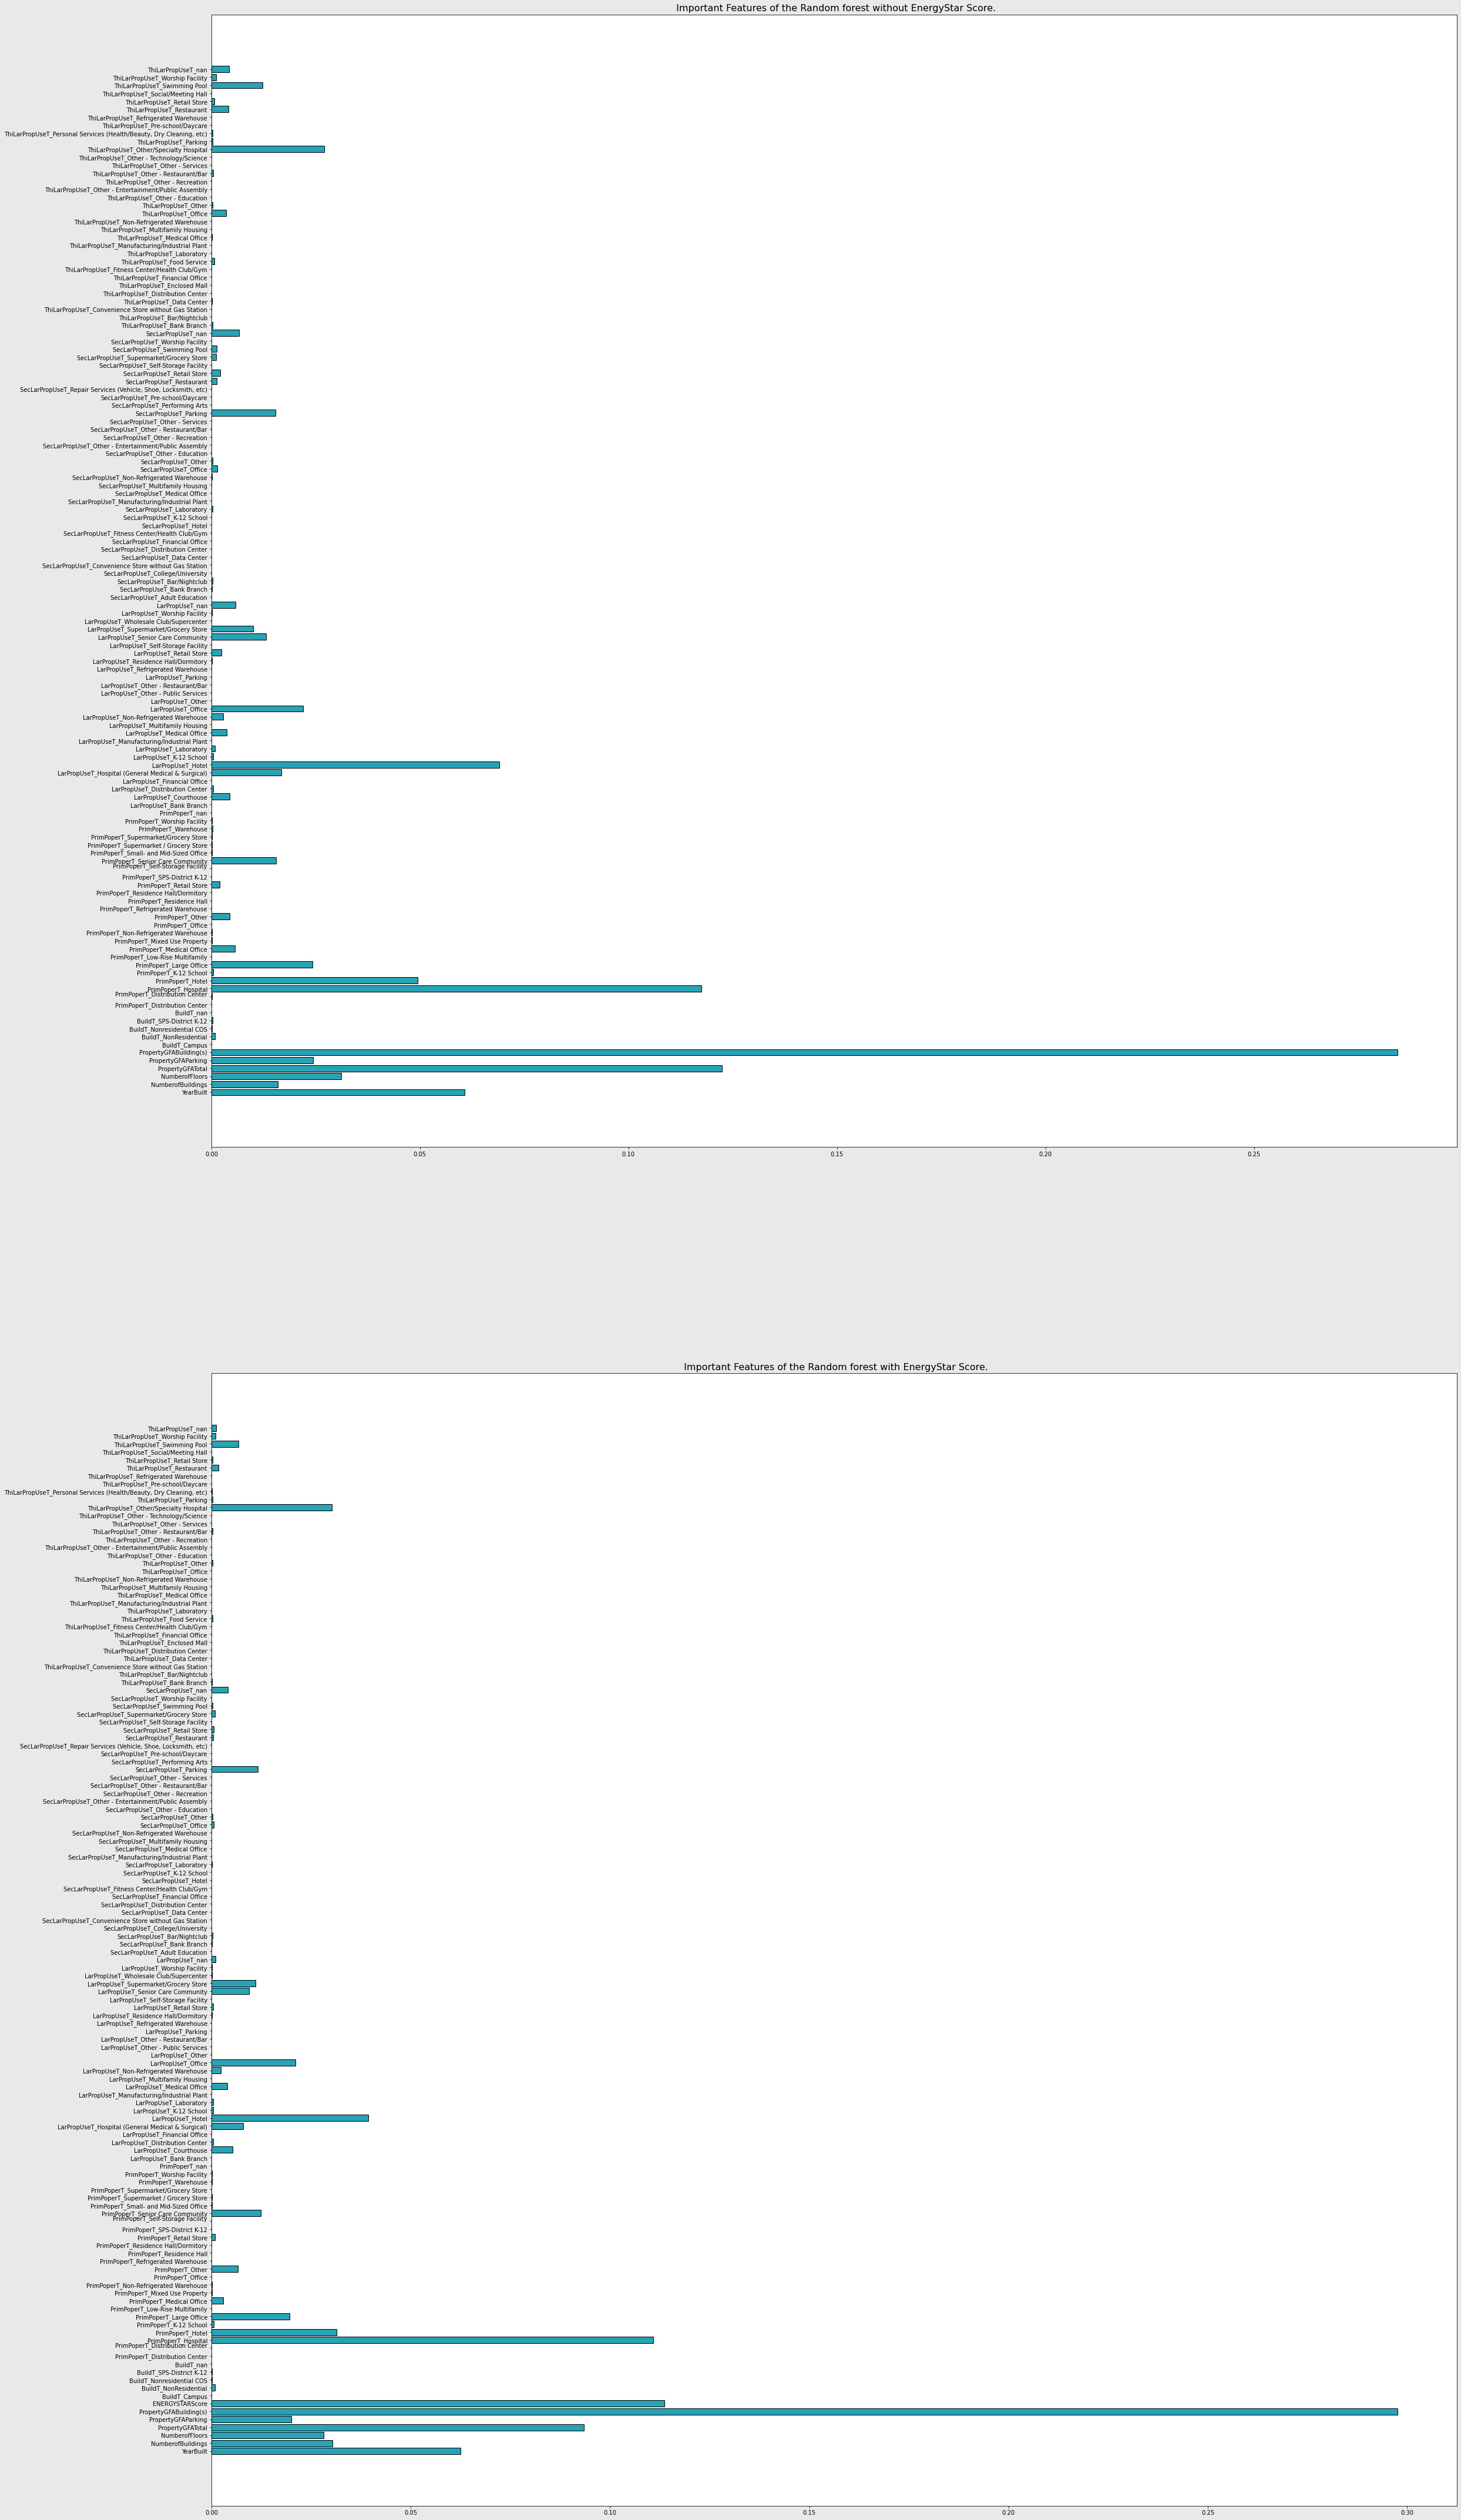

In [45]:
importantFeaturesPlot(RFImportantFeatures)

Pour l'algorithme de randomForest, on voit que l'EnergyStar Score a un poids de 14 % sur les décissions.

In [46]:
obs = np.array(y_test)
modelPredictVarWithESS={}
modelPredictVarWithoutESS={}
for key in predictionWithESS.keys():
    j=[]
    h=[]
    for i in range(len(y_test)):
        j.append(np.abs(predictionWithESS[key][i]/obs[i]-1)*100)
        h.append(np.abs(predictionWithoutESS[key][i]/obs[i]-1)*100)
    modelPredictVarWithESS[key]=j
    modelPredictVarWithoutESS[key]=h
    
modelPredictVarWithoutESS = pd.DataFrame(data=modelPredictVarWithoutESS)
modelPredictVarWithESS = pd.DataFrame(data=modelPredictVarWithESS)

(0.0, 500.0)

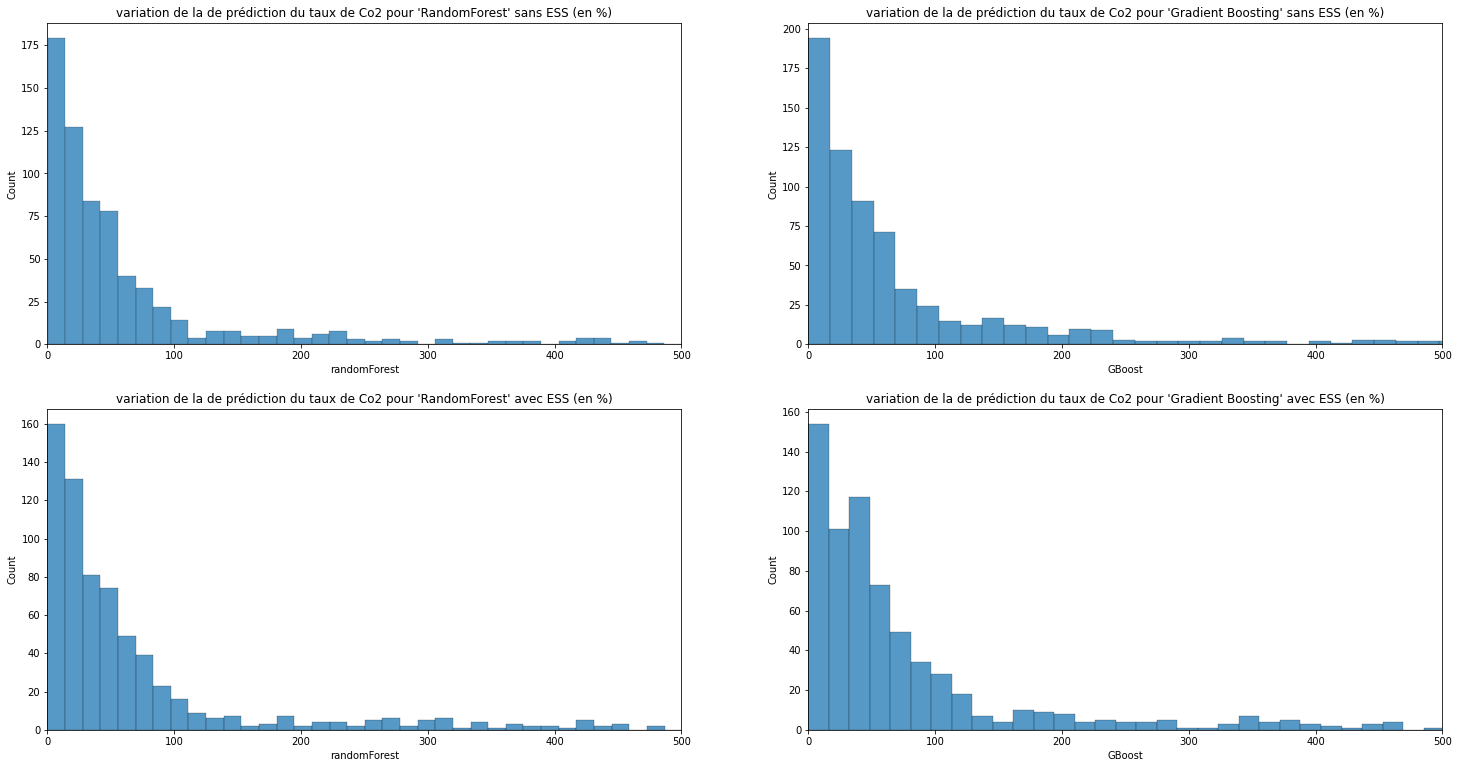

In [47]:
# ['linear','ridge','lasso','randomForest','GBoost']
fig, axes = plt.subplots(2, 2,figsize=(25,13))
sns.histplot(data=modelPredictVarWithoutESS, x='randomForest',stat='count',ax=axes[0,0])
axes[0,0].title.set_text('variation de la de prédiction du taux de Co2 pour \'RandomForest\' sans ESS (en %)')
sns.histplot(data=modelPredictVarWithESS, x='randomForest',stat='count',ax=axes[1,0])
axes[1,0].title.set_text('variation de la de prédiction du taux de Co2 pour \'RandomForest\' avec ESS (en %)')
sns.histplot(data=modelPredictVarWithoutESS, x='GBoost',stat='count',ax=axes[0,1])
axes[0,1].title.set_text('variation de la de prédiction du taux de Co2 pour \'Gradient Boosting\' sans ESS (en %)')
sns.histplot(data=modelPredictVarWithESS, x='GBoost',stat='count',ax=axes[1,1])
axes[1,1].title.set_text('variation de la de prédiction du taux de Co2 pour \'Gradient Boosting\' avec ESS (en %)')
axes[0,1].set_xlim(0,500)
axes[1,1].set_xlim(0,500)
axes[1,0].set_xlim(0,500)
axes[0,0].set_xlim(0,500)

les graphiques montrent pour random forest et gradient boosting, la distribution d'erreurs de prédiction par rapport aux observations (en %) avec et sans EnergyStar Score

In [48]:
cprint("métriques pour le modèle Random Forest sans EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithoutESS['randomForest'].describe(percentiles=[.25, .5, .75]))
cprint("métriques pour le modèle Random Forest avec EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithESS['randomForest'].describe(percentiles=[.25, .5, .75]))
cprint("métriques pour le modèle Gradient Boosting sans EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithoutESS['GBoost'].describe(percentiles=[.25, .5, .75]))
cprint("métriques pour le modèle Gradient Boosting avec EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithESS['GBoost'].describe(percentiles=[.25, .5, .75])) 

métriques pour le modèle Random Forest sans EnegyStarScore :



count     696.000000
mean      100.466151
std       259.935104
min         0.158833
25%        13.212104
50%        34.496886
75%        74.972104
max      4362.891674
Name: randomForest, dtype: float64

métriques pour le modèle Random Forest avec EnegyStarScore :



count     696.000000
mean      100.973265
std       228.087992
min         0.010126
25%        15.072834
50%        37.201153
75%        76.827917
max      3657.282120
Name: randomForest, dtype: float64

métriques pour le modèle Gradient Boosting sans EnegyStarScore :



count     696.000000
mean      116.538550
std       288.074132
min         0.035509
25%        15.402937
50%        40.245626
75%        91.552317
max      4874.144315
Name: GBoost, dtype: float64

métriques pour le modèle Gradient Boosting avec EnegyStarScore :



count     696.000000
mean      113.418656
std       261.862706
min         0.017680
25%        19.922043
50%        44.981562
75%        91.694322
max      4366.644875
Name: GBoost, dtype: float64

on peut voir les différents quartiles pour random forest et gradient boosting. On voit que la médiane est plus petite pour le modèle de random Forest. De plus l'erreur maximum est plus basse pour ce modèle. Pour le modèle GradientBoost la médiane est de 40% sans ESS et de 44% avec ESS.

# Prédiction énergétique:

In [49]:
Y = dfUsed['SiteEnergyUse(kBtu)']
XwithoutEnergyScore = dfUsed.loc[:,~dfUsed.columns.isin(['ENERGYSTARScore', 'TotalGHGEmissions','SiteEnergyUse(kBtu)'])]
X_train, X_test, y_train, y_test = splitSet(XwithoutEnergyScore,Y)
cprint("Errors without EnegyStarScore :\n",'magenta','on_white',attrs=['bold'])
importantFeaturesWithoutESS, predictionWithoutESS = modelisation(X_train, X_test, y_train, y_test)

Y = dfUsed['SiteEnergyUse(kBtu)']
XEnergyScore = dfUsed.loc[:,~dfUsed.columns.isin(['TotalGHGEmissions','SiteEnergyUse(kBtu)'])]
X_train, X_test, y_train, y_test = splitSet(XEnergyScore,Y)
cprint("Errors with EnegyStarScore :\n",'magenta','on_white',attrs=['bold'])
importantFeaturesWithESS, predictionWithESS = modelisation(X_train, X_test, y_train, y_test)

RFImportantFeatures = [importantFeaturesWithoutESS[0],importantFeaturesWithoutESS[1],importantFeaturesWithESS[0],importantFeaturesWithESS[1]]

Errors without EnegyStarScore :

linear :   Score R2 : -1.3298074704714937e+28 	 RMSE : 1.1627658698455532e+20
                     
ridge :   Score R2 : 77.48904587405305 	 RMSE : 4784040.448697973
                     
lasso :   Score R2 : 75.63432222132114 	 RMSE : 4977223.463132536
                     
randomForest :   Score R2 : 84.7753196240927 	 RMSE : 3934340.861455687
                     
GBoost :   Score R2 : 88.39556905182211 	 RMSE : 3434866.131309063
                     
Errors with EnegyStarScore :

linear :   Score R2 : -2.1566136138969087e+28 	 RMSE : 1.480757914777405e+20
                     
ridge :   Score R2 : 78.71223585688534 	 RMSE : 4652248.626742213
                     
lasso :   Score R2 : 77.56588410525167 	 RMSE : 4775868.617622001
                     
randomForest :   Score R2 : 88.93857667060529 	 RMSE : 3353539.2844073945
                     
GBoost :   Score R2 : 91.50423750132998 	 RMSE : 2938996.5278436923
                     


On remarque que encore une fois le modèle ayant la meilleure RMSE est le modèle GradientBoost avec et sans ESS. on remarque que ESS induit une faible amélioration des 2 meilleurs modèles (random Forest et Gradient Boost.

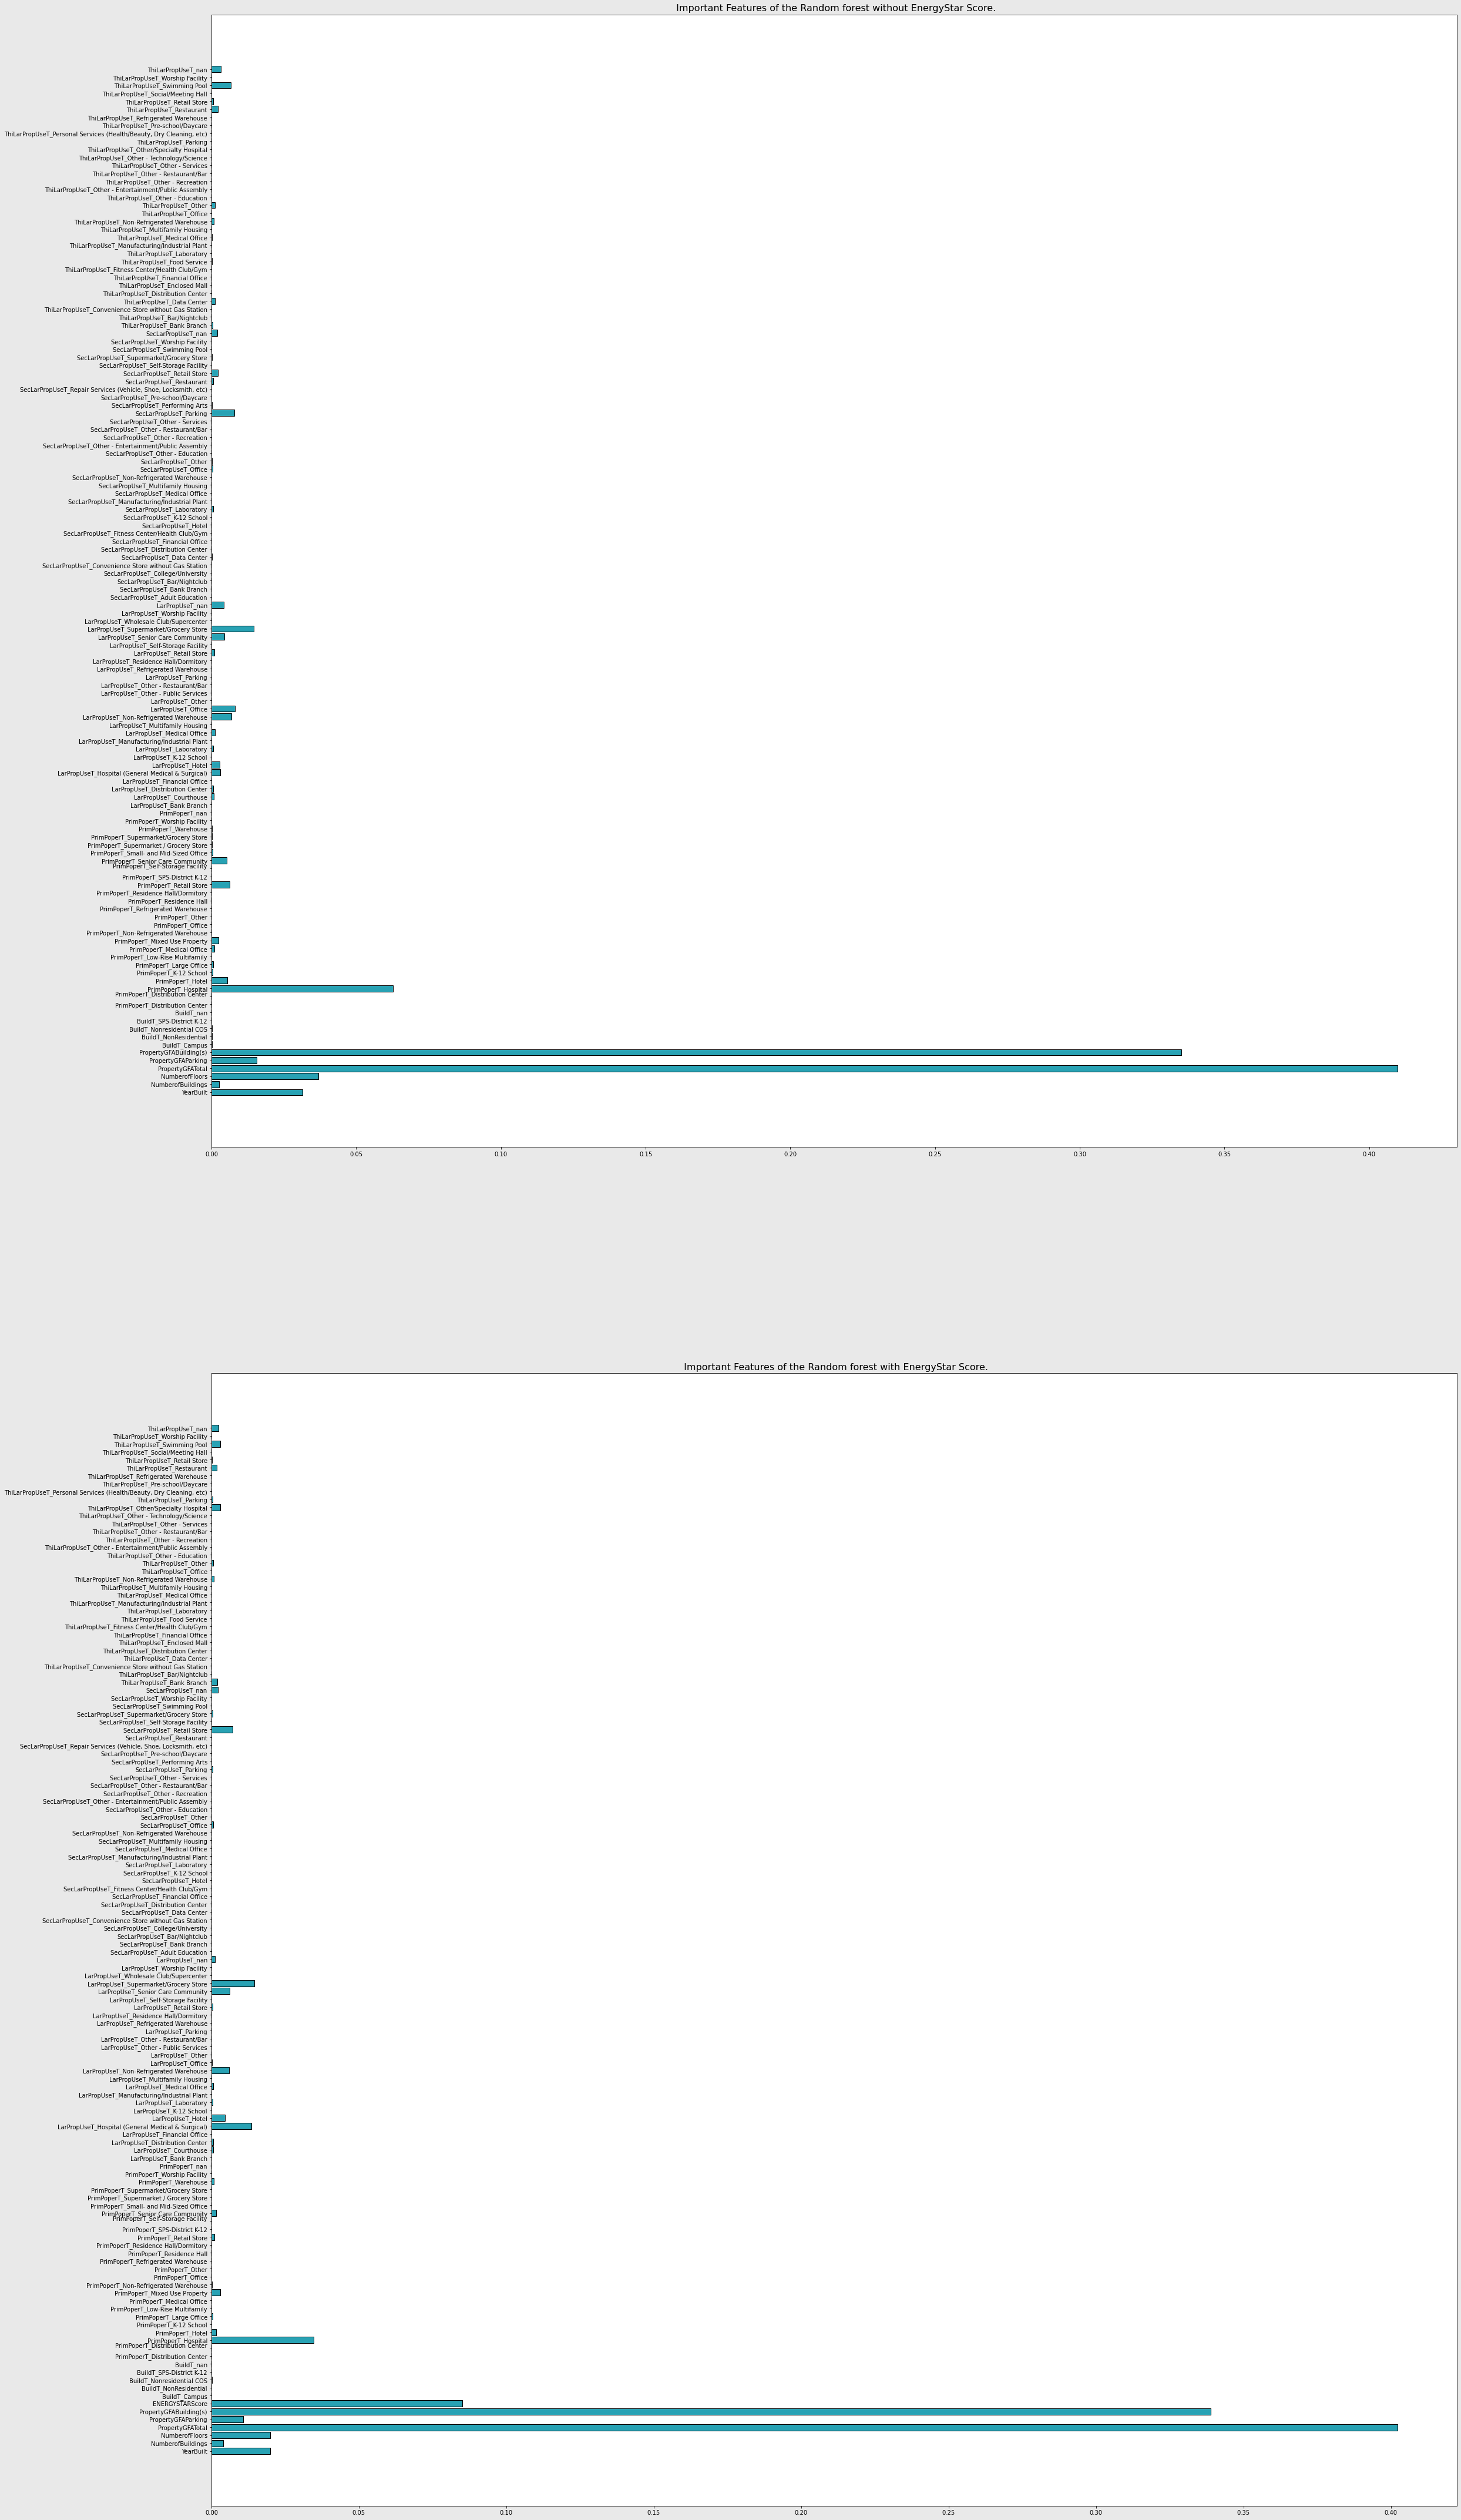

In [50]:
importantFeaturesPlot(RFImportantFeatures)

Pour l'algorithme de randomForest, on voit que l'EnergyStar Score a un poids de 8 % sur les décissions.

In [51]:
obs = np.array(y_test)
modelPredictVarWithESS={}
modelPredictVarWithoutESS={}
for key in predictionWithESS.keys():
    j=[]
    h=[]
    for i in range(len(y_test)):
        j.append(np.abs(predictionWithESS[key][i]/obs[i]-1)*100)
        h.append(np.abs(predictionWithoutESS[key][i]/obs[i]-1)*100)
    modelPredictVarWithESS[key]=j
    modelPredictVarWithoutESS[key]=h
    
modelPredictVarWithoutESS = pd.DataFrame(data=modelPredictVarWithoutESS)
modelPredictVarWithESS = pd.DataFrame(data=modelPredictVarWithESS)

(0.0, 500.0)

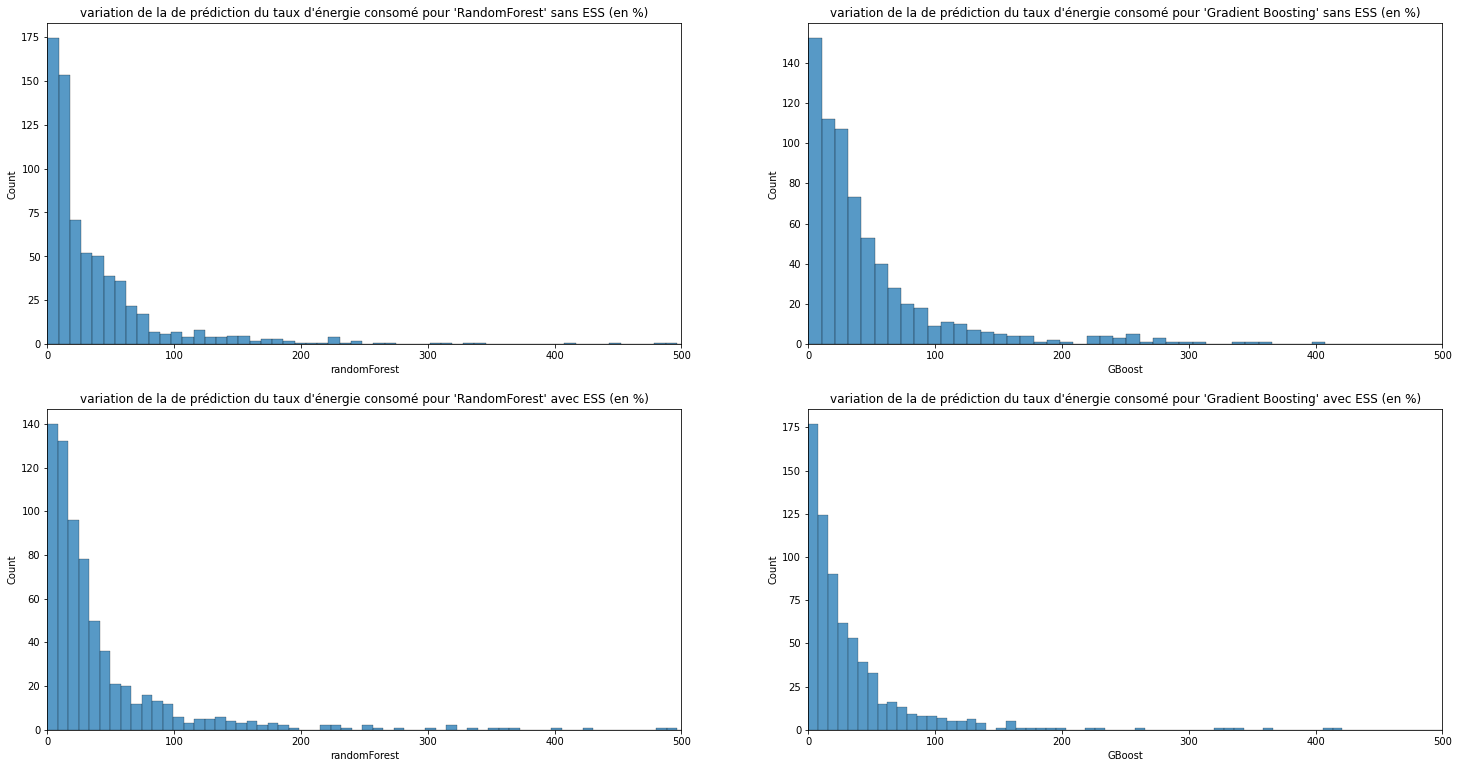

In [52]:
# ['linear','ridge','lasso','randomForest','GBoost']
fig, axes = plt.subplots(2, 2,figsize=(25,13))
sns.histplot(data=modelPredictVarWithoutESS, x='randomForest',stat='count',ax=axes[0,0])
axes[0,0].title.set_text('variation de la de prédiction du taux d\'énergie consomé pour \'RandomForest\' sans ESS (en %)')
sns.histplot(data=modelPredictVarWithESS, x='randomForest',stat='count',ax=axes[1,0])
axes[1,0].title.set_text('variation de la de prédiction du taux d\'énergie consomé pour \'RandomForest\' avec ESS (en %)')
sns.histplot(data=modelPredictVarWithoutESS, x='GBoost',stat='count',ax=axes[0,1])
axes[0,1].title.set_text('variation de la de prédiction du taux d\'énergie consomé pour \'Gradient Boosting\' sans ESS (en %)')
sns.histplot(data=modelPredictVarWithESS, x='GBoost',stat='count',ax=axes[1,1])
axes[1,1].title.set_text('variation de la de prédiction du taux d\'énergie consomé pour \'Gradient Boosting\' avec ESS (en %)')
axes[0,1].set_xlim(0,500)
axes[1,1].set_xlim(0,500)
axes[1,0].set_xlim(0,500)
axes[0,0].set_xlim(0,500)

In [53]:
cprint("métriques pour le modèle Random Forest sans EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithoutESS['randomForest'].describe(percentiles=[.25, .5, .75]))
cprint("métriques pour le modèle Random Forest avec EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithESS['randomForest'].describe(percentiles=[.25, .5, .75]))
cprint("métriques pour le modèle Gradient Boosting sans EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithoutESS['GBoost'].describe(percentiles=[.25, .5, .75]))
cprint("métriques pour le modèle Gradient Boosting avec EnegyStarScore :\n",'red','on_white',attrs=['bold'])
display(modelPredictVarWithESS['GBoost'].describe(percentiles=[.25, .5, .75])) 

métriques pour le modèle Random Forest sans EnegyStarScore :



count     696.000000
mean       44.327654
std        96.854975
min         0.073011
25%         8.962807
50%        19.990429
75%        48.232498
max      1958.605693
Name: randomForest, dtype: float64

métriques pour le modèle Random Forest avec EnegyStarScore :



count     696.000000
mean       49.393294
std       110.309508
min         0.031135
25%         9.886096
50%        22.891873
75%        46.639013
max      2093.807983
Name: randomForest, dtype: float64

métriques pour le modèle Gradient Boosting sans EnegyStarScore :



count     696.000000
mean       55.644094
std       115.317589
min         0.160833
25%        12.310324
50%        28.926586
75%        58.702517
max      2235.013653
Name: GBoost, dtype: float64

métriques pour le modèle Gradient Boosting avec EnegyStarScore :



count     696.000000
mean       38.254753
std        96.695088
min         0.078335
25%         7.741929
50%        19.815254
75%        42.372620
max      2199.531005
Name: GBoost, dtype: float64

on remarque que les quartiles pour les 2 modèles sont relativemnt similaire et que la présence de ESS ne perturbe pas les quartiles.

## Conclusion

Pour conclure le meilleur modèle pour la prédiction des émissions de CO2 et de consomation énergétique des batiments est le Gradient Boosting. 
L'énergieStar Score n'a pas un impact significatif sur la réduction de l'erreur RMSE pour les 2 objectifs. il n'entraine que faiblement des meilleurs résultats de prédiction de consomlation d'énergie pour les quartiles.
Au vu de son coût il n'est pas nécessaire de l'introduire dans les modèles.
